# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# These two are required to work in local mode
# in my laptop
import findspark
findspark.init()

# All libraries required fo rthis analysis
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb

# I like inline plots
%matplotlib inline

# Setting to display max column width
pd.set_option('display.max_colwidth', None)

/Users/pwolter/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName('Sparkify') \
        .getOrCreate()

In [3]:
spark

In [4]:
# To show output to fit Jupyter notebook
# ref: https://stackoverflow.com/questions/50523950/improve-pyspark-dataframe-show-output-to-fit-jupyter-notebook
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
# spark.conf.set("spark.executor.memory", "8g")
# spark.conf.set("spark.sql.tungsten.enabled", False)
# spark.conf.set("spark.executor.cores", 1)
#spark.conf.set("spark.driver.memory", "4g")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Cerate a Dataframe reading the JSON file
all_df = spark.read.json('mini_sparkify_event_data.json')

In [6]:
all_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
# print the dataset schema to check columns types
all_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df = all_df.sample(withReplacement=False, fraction=0.1, seed=42)
# df = all_df.select("*").persist()

In [9]:
df = df.withColumn("userId", df["userId"].cast(IntegerType()))

In [10]:
# Let's print total number of rows and columns
print("Total number fo rows: {}\nNumber of columns: {}".format(df.count(), len(df.columns)))

Total number fo rows: 28820
Number of columns: 18


In [11]:
# Convert it to Pandas to do a quick check
pd_df = df.toPandas()

In [12]:
# I like to see the data info provides in contrast to Spark's
# that looks incomplete
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artist         22864 non-null  object 
 1   auth           28820 non-null  object 
 2   firstName      27978 non-null  object 
 3   gender         27978 non-null  object 
 4   itemInSession  28820 non-null  int64  
 5   lastName       27978 non-null  object 
 6   length         22864 non-null  float64
 7   level          28820 non-null  object 
 8   location       27978 non-null  object 
 9   method         28820 non-null  object 
 10  page           28820 non-null  object 
 11  registration   27978 non-null  float64
 12  sessionId      28820 non-null  int64  
 13  song           22864 non-null  object 
 14  status         28820 non-null  int64  
 15  ts             28820 non-null  int64  
 16  userAgent      27978 non-null  object 
 17  userId         27978 non-null  float64
dtypes: flo

In [13]:
# Pandas describe gives lots of good information I like to see
# like unique values per column, count (and NaN by default) etc.
pd_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
artist,22864,6616,Kings Of Leon,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth,28820,4,Logged In,27975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstName,27978,189,Payton,991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,27978,2,F,15554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itemInSession,28820,NaN,NaN,NaN,116.07,130.825,0,27,72,159,1313
lastName,27978,172,Campbell,1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,22864,NaN,NaN,NaN,249.431,100.09,11.3628,199.49,235.232,277.446,2560.76
level,28820,2,paid,23043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,27978,113,"Los Angeles-Long Beach-Anaheim, CA",3063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
method,28820,2,PUT,26204,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.persist()

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
The Velvet Underg...,Logged In,Micah,M,82,Long,260.46649,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Win...",9
Britt Nicole,Logged In,Micah,M,83,Long,229.8771,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Walk On The Water,200,1538353146000,"""Mozilla/5.0 (Win...",9
null,Logged In,Micah,M,84,Long,null,free,Boston-Cambridge-...,GET,Roll Advert,1538331630000,8,null,200,1538353150000,"""Mozilla/5.0 (Win...",9
Ratatat,Logged In,Micah,M,88,Long,229.77261,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Swisha,200,1538353744000,"""Mozilla/5.0 (Win...",9
Lambert_ Hendrick...,Logged In,Colin,M,63,Freeman,139.04934,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Halloween Spooks,200,1538354806000,Mozilla/5.0 (Wind...,30
Vampire Weekend,Logged In,Alexi,F,6,Warren,243.04281,paid,Spokane-Spokane V...,PUT,NextSong,1532482662000,53,The Kids Dont St...,200,1538355254000,Mozilla/5.0 (Wind...,54
The All-American ...,Logged In,Colin,M,66,Freeman,238.86322,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Move Along,200,1538355473000,Mozilla/5.0 (Wind...,30
null,Logged Out,null,null,100,null,null,free,null,GET,Home,null,8,null,200,1538355745000,null,null
null,Logged Out,null,null,101,null,null,free,null,GET,Help,null,8,null,200,1538355807000,null,null
null,Logged In,Warren,M,1,Miller,null,free,Baltimore-Columbi...,PUT,Logout,1538169823000,240,null,307,1538356651000,Mozilla/5.0 (Wind...,4


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
# I first create a second dataframe with only the columns I am interested
columns_to_include = ['auth', 'gender', 'length', 'level', 'location', 'page', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']

In [16]:
df_new = df.select(columns_to_include).persist()

In [17]:
df_new.select("*")

auth,gender,length,level,location,page,sessionId,song,status,ts,userAgent,userId
Logged In,M,260.46649,free,Boston-Cambridge-...,NextSong,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Win...",9
Logged In,M,229.8771,free,Boston-Cambridge-...,NextSong,8,Walk On The Water,200,1538353146000,"""Mozilla/5.0 (Win...",9
Logged In,M,null,free,Boston-Cambridge-...,Roll Advert,8,null,200,1538353150000,"""Mozilla/5.0 (Win...",9
Logged In,M,229.77261,free,Boston-Cambridge-...,NextSong,8,Swisha,200,1538353744000,"""Mozilla/5.0 (Win...",9
Logged In,M,139.04934,paid,"Bakersfield, CA",NextSong,29,Halloween Spooks,200,1538354806000,Mozilla/5.0 (Wind...,30
Logged In,F,243.04281,paid,Spokane-Spokane V...,NextSong,53,The Kids Dont St...,200,1538355254000,Mozilla/5.0 (Wind...,54
Logged In,M,238.86322,paid,"Bakersfield, CA",NextSong,29,Move Along,200,1538355473000,Mozilla/5.0 (Wind...,30
Logged Out,null,null,free,null,Home,8,null,200,1538355745000,null,null
Logged Out,null,null,free,null,Help,8,null,200,1538355807000,null,null
Logged In,M,null,free,Baltimore-Columbi...,Logout,240,null,307,1538356651000,Mozilla/5.0 (Wind...,4


In [18]:
df_new = df_new.withColumn('churn', when(df_new['page'] == 'Cancellation Confirmation', 1).otherwise(0))
df_new = df_new.withColumn('churn', when(df_new['page'] == 'Submit Downgrade', 1).otherwise(df_new['churn']))
df_new = df_new.withColumn("churn", df_new["churn"].cast(IntegerType()))

In [19]:
df_new.groupby('churn').count().sort('count', ascending=[False])

churn,count
0,28812
1,8


In [20]:
churnIndexer = StringIndexer(inputCol="churn", outputCol="label")

In [21]:
df_new = churnIndexer.fit(df_new).transform(df_new)

In [22]:
df_new = df_new.drop('churn')

In [23]:
# Based on the previous information I am exploring some columns I think
# are interesting or may add value to the prediction of churn
df_new.groupby('auth').count() \
.sort('count', ascending=False)

auth,count
Logged In,27975
Logged Out,828
Guest,14
Cancelled,3


In [24]:
# and compute the distribution
df_new.groupby('gender').count().sort('count', ascending=False)

gender,count
F,15554
M,12424
null,842


In [25]:
df_new = df_new.withColumn('gender', when(isnull('gender'), 'U').otherwise(df_new['gender']))

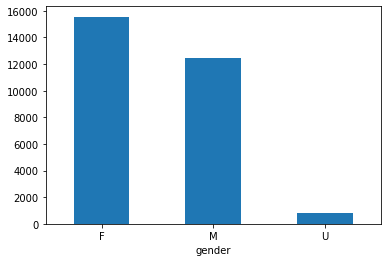

In [26]:
# with a graph as well
df_new.groupby('gender').count().sort('count', ascending=False) \
.toPandas().plot.bar(x='gender', y='count', rot=0, legend=None);

In [27]:
genderIndexer = StringIndexer(inputCol="gender", outputCol="gender_int")

In [28]:
df_new = genderIndexer.fit(df_new).transform(df_new)

In [29]:
df_new = df_new.drop('gender')

In [30]:
# Let's see the 'level' distribution of subscribers
df_new.groupby('level').count().sort('level', ascending=[False])

level,count
paid,23043
free,5777


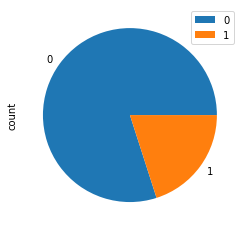

In [31]:
# A pie chart makes sense here, most of our users are paid users
df_new.groupby('level').count().sort('level', ascending=[False]) \
.toPandas().plot.pie(y='count');

In [32]:
levelIndexer = StringIndexer(inputCol="level", outputCol="level_int")

In [33]:
df_new = levelIndexer.fit(df_new).transform(df_new)

In [34]:
df_new = df_new.drop('level')

In [35]:
df_new.select("*")

auth,length,location,page,sessionId,song,status,ts,userAgent,userId,label,gender_int,level_int
Logged In,260.46649,Boston-Cambridge-...,NextSong,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Win...",9,0.0,1.0,1.0
Logged In,229.8771,Boston-Cambridge-...,NextSong,8,Walk On The Water,200,1538353146000,"""Mozilla/5.0 (Win...",9,0.0,1.0,1.0
Logged In,null,Boston-Cambridge-...,Roll Advert,8,null,200,1538353150000,"""Mozilla/5.0 (Win...",9,0.0,1.0,1.0
Logged In,229.77261,Boston-Cambridge-...,NextSong,8,Swisha,200,1538353744000,"""Mozilla/5.0 (Win...",9,0.0,1.0,1.0
Logged In,139.04934,"Bakersfield, CA",NextSong,29,Halloween Spooks,200,1538354806000,Mozilla/5.0 (Wind...,30,0.0,1.0,0.0
Logged In,243.04281,Spokane-Spokane V...,NextSong,53,The Kids Dont St...,200,1538355254000,Mozilla/5.0 (Wind...,54,0.0,0.0,0.0
Logged In,238.86322,"Bakersfield, CA",NextSong,29,Move Along,200,1538355473000,Mozilla/5.0 (Wind...,30,0.0,1.0,0.0
Logged Out,null,null,Home,8,null,200,1538355745000,null,null,0.0,2.0,1.0
Logged Out,null,null,Help,8,null,200,1538355807000,null,null,0.0,2.0,1.0
Logged In,null,Baltimore-Columbi...,Logout,240,null,307,1538356651000,Mozilla/5.0 (Wind...,4,0.0,1.0,1.0


In [36]:
# Let's check the 'page' column
df_new.groupby('page').count() \
.sort('count', ascending=False)

page,count
NextSong,22864
Home,1478
Thumbs Up,1279
Add to Playlist,648
Add Friend,466
Roll Advert,403
Logout,329
Login,309
Thumbs Down,255
Downgrade,212


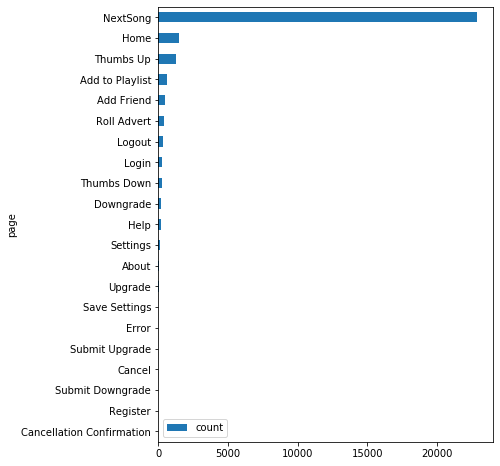

In [37]:
# The same in a graphical representation
df_new.groupby('page').count().sort('count', ascending=True) \
.toPandas().plot.barh(x='page', y='count', rot=0, figsize=(6,8));

In [38]:
# We have 3 status:
df_new.groupby('status').count().sort('count', ascending=[False])

status,count
200,26103
307,2692
404,25


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [39]:
# let's see what the 'location' column has to offer:
df_new.groupby('location').count().sort('count', ascending=[False]).show(20, False)

+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA         |3063 |
|New York-Newark-Jersey City, NY-NJ-PA      |2413 |
|Boston-Cambridge-Newton, MA-NH             |1360 |
|Houston-The Woodlands-Sugar Land, TX       |919  |
|null                                       |842  |
|Charlotte-Concord-Gastonia, NC-SC          |820  |
|Dallas-Fort Worth-Arlington, TX            |798  |
|Louisville/Jefferson County, KY-IN         |640  |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD|591  |
|St. Louis, MO-IL                           |524  |
|Phoenix-Mesa-Scottsdale, AZ                |501  |
|Chicago-Naperville-Elgin, IL-IN-WI         |492  |
|Wilson, NC                                 |490  |
|Vineland-Bridgeton, NJ                     |474  |
|Danville, VA                               |451  |
|Denver-Aurora-Lakewood, CO                 |451  |
|San Antonio

In [40]:
# US according to 'www2.census.gov' can be divided in 4 mayor regions: Region 1: Northeast, 
# Region 2: Midwest, Region 3: South and Region 4: West.
# Each of these regions can be divided further, for example, Region 1 is compromised of Division 1: 
# New England with Connecticut, Maine, Massachusetts, New Hampshire, RhodeIsland and, Vermont and so for.
# I just divided it into 4 Regions: Northeast, Midwest, South and West.
location_regions = {
    'Northeast': ['NJ', 'NY', 'PA', 'CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'Midwest': ['IN', 'IL', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

In [41]:
# I am not sure how I am going to use this information (if I use it at all)
# So for now just extract the State information after the ',' with the below
# function
# def split_location_by_state(df):
#     # Then I split the 'location' column bu ',' and extract the second
#     # item, the state information
#     # In multiple cases thsi is a group of various States together. I am
#     # fine with that so far ...
#     body_length = udf(lambda x: len(x), IntegerType())
#     df = df.withColumn("BodyLength", body_length(df.words))
#     region_state = udf(lambda x: 
    
#     # We return the modified Dataframe back
#     return df

In [42]:
df_new = df_new.withColumn('state', split(df_new['location'], ',').getItem(1))

In [43]:
df_new = df_new.drop('location')

In [44]:
# A quick check on our newly created column 
df_new.select('state').distinct().sort('state').show(10, False)

+------------+
|state       |
+------------+
|null        |
| AK         |
| AL         |
| AR         |
| AZ         |
| CA         |
| CO         |
| CT         |
| DC-VA-MD-WV|
| FL         |
+------------+
only showing top 10 rows



In [45]:
# let's check the 'userAgent' column
df_new.select('userAgent').show(5, False)

+---------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                      |
+---------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"|
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                       |
+---------------------------------------------------------------------------------------

In [46]:
df_new = df_new.withColumn('os', regexp_extract(col('userAgent'), r'\((\w+);?\s+', 1))

In [47]:
df_new = df_new.withColumn('browser', regexp_extract(col('userAgent'), r'\s(\w+)/\d+.\d+"?$', 1))

In [48]:
df_new.groupby('browser').count().sort('count', ascending=[False])

browser,count
Safari,16827
Firefox,5608
,5543
null,842


In [49]:
df_new = df_new.fillna('Undefined', subset='browser')

In [50]:
df_new = df_new.withColumn('browser', when(df_new['browser'] == '', 'Undefined').otherwise(df_new['browser']))

In [51]:
df_new.groupby('browser').count().sort('count', ascending=[False])

browser,count
Safari,16827
Undefined,6385
Firefox,5608


In [52]:
df_new = df_new.fillna('Undefined', subset='os')

In [53]:
df_new.groupby('os').count().sort('count', ascending=[False])

os,count
Windows,13420
Macintosh,10225
compatible,1157
iPad,1153
iPhone,1087
X11,936
Undefined,842


In [54]:
osIndexer = StringIndexer(inputCol="os", outputCol="os_int")

In [55]:
df_new = osIndexer.fit(df_new).transform(df_new)

In [56]:
browserIndexer = StringIndexer(inputCol="browser", outputCol="browser_int")

In [57]:
df_new = browserIndexer.fit(df_new).transform(df_new)

In [58]:
df_new = df_new.drop(*['os', 'browser'])

In [59]:
df_new.select(df_new.ts, length(df_new.ts)).show(5, False)

+-------------+----------+
|ts           |length(ts)|
+-------------+----------+
|1538352886000|13        |
|1538353146000|13        |
|1538353150000|13        |
|1538353744000|13        |
|1538354806000|13        |
+-------------+----------+
only showing top 5 rows



In [60]:
# We do have the 'ts' in miliseconds, as it is 13 digits long, so we need to first
# convert it to seconds dividing it by 1000. Then convert it to a unix timestamp to
# use 'to_date' function to finally convert the result to a date we can use.
#df = df.withColumn('ts_date', to_date(from_unixtime(col('ts') / 1000, 'yyyy-MM-dd HH:mm:ss')))
df_new = df_new.withColumn('ts_date', from_unixtime(col('ts') / 1000))

In [61]:
# 0 - Sunday, 1 - Monday, etc.
df_new = df_new.withColumn('day_of_week', dayofweek(col('ts_date')))
# Integer value for the hour
df_new = df_new.withColumn('hour', hour(col('ts_date')))

In [62]:
songs_per_hour = df_new.filter(df_new.page == "NextSong")\
                .groupby(df_new.hour).count()\
                .orderBy(df_new.hour.cast("float")).toPandas()

In [63]:
songs_per_day_of_week = df_new.filter(df_new.page == "NextSong")\
                .groupby(df_new.day_of_week).count()\
                .orderBy(df_new.day_of_week.cast("float")).toPandas()

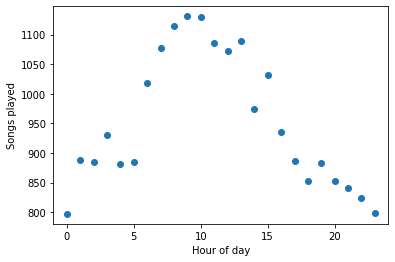

In [64]:
songs_per_hour.hour = pd.to_numeric(songs_per_hour.hour)

plt.scatter(songs_per_hour["hour"], songs_per_hour["count"])
plt.xlim(-1, 24);
# plt.ylim(0, 1.2 * max(songs_per_hour["count"]))
plt.xlabel("Hour of day")
plt.ylabel("Songs played");

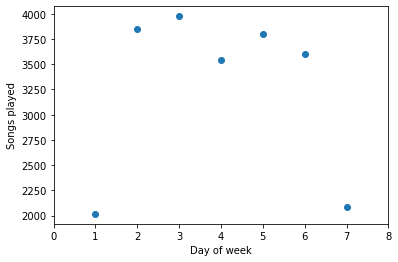

In [65]:
songs_per_day_of_week.day_of_week = pd.to_numeric(songs_per_day_of_week.day_of_week)

plt.scatter(songs_per_day_of_week["day_of_week"], songs_per_day_of_week["count"])
plt.xlim(0, 8);
# plt.ylim(0, 1.2 * max(songs_per_hour["count"]))
plt.xlabel("Day of week")
plt.ylabel("Songs played");

In [66]:
df_1 = df_new.select('userId', 'page')\
        .where('page = "Save Settings"')\
        .groupby('userId').count()\
       .withColumnRenamed('count', 'saved_settings')

In [67]:
df_1.select("*")

userId,saved_settings
65,1
81,1
200004,1
140,1
132,1
6,1
142,1
20,1
61,1
88,1


In [68]:
df_new = df_new.join(df_1, 'userId', 'inner')

In [69]:
df_2 = df_new.select('userId', 'song')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'num_songs')
df_2.select("*")

userId,num_songs
65,240
81,228
200004,217
140,640
132,231
6,382
142,234
20,224
61,186
88,249


In [70]:
df_new = df_new.join(df_2, 'userId', 'inner')

In [71]:
df_3 = df_new.select('userId', 'page')\
        .where('page = "Thumbs Up"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_up')
df_3.select("*")

userId,thumbs_up
65,8
81,8
200004,7
140,27
132,9
6,20
142,10
20,10
61,4
88,10


In [72]:
df_new = df_new.join(df_3, 'userId', 'inner')

In [73]:
df_4 = df_new.select('userId', 'page')\
        .where('page = "Roll Advert"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'num_advertisement')
df_4.select("*")

userId,num_advertisement
65,2
140,12
6,1
61,7
88,3
100,5
100013,3
39,11
24,4
121,8


In [74]:
df_new = df_new.join(df_4, 'userId', 'inner')

In [75]:
df_5 = df_new.select('userId', 'page')\
        .where('page = "Thumbs Down"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_down')
df_5.select("*")

userId,thumbs_down
65,2
140,7
6,3
100,4
100013,1
39,2
121,1
100018,1
42,4
118,5


In [76]:
df_new = df_new.join(df_5, 'userId', 'inner')

In [77]:
df_6 = df_new.select('userId', 'page')\
        .where('page = "Add to Playlist"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'playlist_added')
df_6.select("*")

userId,playlist_added
65,7
140,16
6,12
100,4
100013,3
39,20
121,2
100018,1
42,9
118,6


In [78]:
df_new = df_new.join(df_6, 'userId', 'inner')

In [79]:
df_7 = df_new.select('userId', 'page')\
        .where('page = "Add Friend"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'friend_added')
df_7.select("*")

userId,friend_added
65,4
140,16
6,5
100,6
100013,6
39,16
100018,5
42,9
118,2
46,4


In [80]:
df_new = df_new.join(df_7, 'userId', 'inner')

In [81]:
df_8 = df_new.select('userId', 'page')\
        .where('page = "Error"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'errors_pages')
df_8.select("*")

userId,errors_pages
140,1
6,1


In [82]:
df_new = df_new.join(df_8, 'userId', 'inner')

In [83]:
df_9 = df_new.where('page == "NextSong"') \
        .groupby(['userId', 'sessionId']) \
        .count() \
        .groupby(['userId']) \
        .agg({'count':'avg'}) \
        .withColumnRenamed('avg(count)', 'songs_persession')
df_9.select("*")

userId,songs_persession
140,8.610169491525424
6,15.55


In [84]:
# Need to run
df_new = df_new.join(df_9, 'userId', 'inner')

In [85]:
df_new.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- auth: string (nullable = true)
 |-- length: double (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- label: double (nullable = false)
 |-- gender_int: double (nullable = false)
 |-- level_int: double (nullable = false)
 |-- state: string (nullable = true)
 |-- os_int: double (nullable = false)
 |-- browser_int: double (nullable = false)
 |-- ts_date: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- num_advertisement: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- friend_added: long (nullable = fal

In [86]:
df_new = df_new.drop(*['ts_date', 'state', 'userAgent', 'ts', 'status', 'song', 'sessionId', 'page', 'length', 'auth', 'userId'])

In [87]:
df_new.persist()

label,gender_int,level_int,os_int,browser_int,day_of_week,hour,saved_settings,num_songs,thumbs_up,num_advertisement,thumbs_down,playlist_added,friend_added,errors_pages,songs_persession
0.0,0.0,1.0,0.0,0.0,2,9,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,9,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,9,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,9,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,10,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,10,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,10,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,2,10,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,3,15,1,640,27,12,7,16,16,1,8.610169491525424
0.0,0.0,1.0,0.0,0.0,3,15,1,640,27,12,7,16,16,1,8.610169491525424


In [88]:
feature_columns = ['gender_int', 'level_int', 'os_int', 'browser_int', 'day_of_week', 
                   'hour', 'saved_settings', 'num_songs', 'thumbs_up', 'num_advertisement', 
                   'thumbs_down', 'playlist_added', 'friend_added', 'errors_pages', 'songs_persession']

In [89]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='vector_features')

In [90]:
df_new = assembler.transform(df_new)

In [91]:
df_new.printSchema()

root
 |-- label: double (nullable = false)
 |-- gender_int: double (nullable = false)
 |-- level_int: double (nullable = false)
 |-- os_int: double (nullable = false)
 |-- browser_int: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- num_advertisement: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- friend_added: long (nullable = false)
 |-- errors_pages: long (nullable = false)
 |-- songs_persession: double (nullable = true)
 |-- vector_features: vector (nullable = true)



In [92]:
normalizer = Normalizer(inputCol='vector_features', outputCol='features')

In [93]:
df_new = normalizer.transform(df_new)

In [94]:
df_new.printSchema()

root
 |-- label: double (nullable = false)
 |-- gender_int: double (nullable = false)
 |-- level_int: double (nullable = false)
 |-- os_int: double (nullable = false)
 |-- browser_int: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- num_advertisement: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- friend_added: long (nullable = false)
 |-- errors_pages: long (nullable = false)
 |-- songs_persession: double (nullable = true)
 |-- vector_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [95]:
data = df_new.select('features', 'label')

In [96]:
data.show(20, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                 |label|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.0,0.0015594644828134502,0.0,0.0,0.0031189289656269005,0.01403518034532105,0.0015594644828134502,0.9980572690006081,0.04210554103596315,0.0187135737937614,0.010916251379694151

In [97]:
spark.catalog.clearCache()

In [98]:
data.cache()

features,label
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015591820...",0.0
"[0.0,0.0015591820...",0.0


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [99]:
seed = 1234

In [100]:
data.select("*")

features,label
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594644...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015594284...",0.0
"[0.0,0.0015591820...",0.0
"[0.0,0.0015591820...",0.0


In [101]:
train, test = data.randomSplit([0.8, 0.2], seed=seed)

## Logistic Regression

In [102]:
lr = LogisticRegression()

In [103]:
%%time
lr_model = lr.fit(train)

CPU times: user 13.6 ms, sys: 6.11 ms, total: 19.7 ms
Wall time: 41.7 s


In [104]:
lr_predictions = lr_model.transform(test)

In [105]:
lr_predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [106]:
lr_predictions.select("*")

features,label,rawPrediction,probability,prediction
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[0.0,0.0,0.0,0.0,...",0.0,"[-Infinity,Infinity]","[0.0,1.0]",1.0


In [107]:
lr_predictions.select('rawPrediction', 'probability', 'prediction')

rawPrediction,probability,prediction
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0
"[-Infinity,Infinity]","[0.0,1.0]",1.0


In [108]:
lr_evaluator = MulticlassClassificationEvaluator(labelCol='label')

In [109]:
f1 = lr_evaluator.evaluate(lr_predictions)

In [110]:
wp = lr_evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)

In [111]:
wr = lr_evaluator.setMetricName("weightedRecall").evaluate(lr_predictions)

In [112]:
accuracy = lr_evaluator.setMetricName("accuracy").evaluate(lr_predictions)

In [113]:
print("F1\tWP\tWR\tAccuracy\n{}\t{}\t{}\t{}\n".format(f1, wp, wr, accuracy))

F1	WP	WR	Accuracy
0.0	0.0	0.0	0.0



## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(featureSubsetStrategy='auto', seed=seed)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label')

In [ ]:
paramGrid = ParamGridBuilder() \
            .addGrid(rf.maxBins, [80, 100]) \
            .addGrid(rf.maxDepth, [1, 2, 4]) \
            .addGrid(rf.numTrees, [10, 50 100]) \
            .addGrid(rf.impurity, ["gini", "entropy"]) \
            .build()

In [ ]:
pipeline = Pipeline(stages=[rf])

In [ ]:
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, numFolds=5)

In [ ]:
%%time
model = cv.fit(train)

In [ ]:
predictions = model.transform(test)

In [ ]:
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

In [ ]:
auc

In [ ]:
predictions.count()

In [ ]:
predictions.printSchema()

In [ ]:
predictions.filter("prediction = 1.0").count()

In [ ]:
true_negative = predictions.select("*").where("prediction = 0 AND label = 0").count()
true_positive = predictions.select("*").where("prediction = 1 AND label = 1").count()
print("True Negative: {}\nTrue Positive: {}".format(true_negative, true_positive))
# Our test predicted 21 customers leaving who actually did leave and also
# predicted 55529 customers not leaving who actually did not leave.

In [ ]:
false_negative = predictions.select("*").where("prediction = 0 AND label = 1").count()
false_positive = predictions.select("*").where("prediction = 1 AND label = 0").count()
print("False Negative: {}\nFalse Positive: {}".format(false_negative, false_positive))
# Our test predicted 0 customers leaving who actually did not leave and
# also predicted 0 customers not leaving who actually did leave.

In [ ]:
predictions.select("RawPrediction","prediction") \
.orderBy("RawPrediction", ascending=True) \
.show(25, False)

In [ ]:
model.bestModel.stages[0].featureImportances

In [ ]:
model.bestModel.stages[0].extractParamMap()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.